In [1]:
from microlensing import microlensing
import ms_helper as msh
import numpy as np


In [ ]:
good_index = []
for i in range(35, 36):
    try:
        ms_event = microlensing(f"https://www.astrouw.edu.pl/ogle/ogle4/ews/2019/blg-{i:04}")
        if ms_event.ogle["fbl"].value == 1.0:
            mid_range=ms_event.ogle["t0"].value
            range_len=ms_event.ogle["tau"].value/2
            min_range, max_range = mid_range-range_len, mid_range+range_len
            data_cut = ms_event.data[(ms_event.data["JHD"]<=max_range) & (ms_event.data["JHD"]>=min_range)]
            a, _, _, chi = msh.independent_meas_linear_fit(n_param=3, x=data_cut["JHD"]-min_range, y=data_cut["I"], y_error=data_cut["I_error"])
            if 0.5 <= chi <= 2 and a[2] < 0 and len(data_cut) > 100:
                tup = (i, chi, mid_range, range_len, len(data_cut))
                good_index.append(tup)
    except:
        continue

good_index

In [17]:
ms_event = microlensing("https://www.astrouw.edu.pl/ogle/ogle4/ews/2019/blg-0035")

Chi: 8.232299366155976


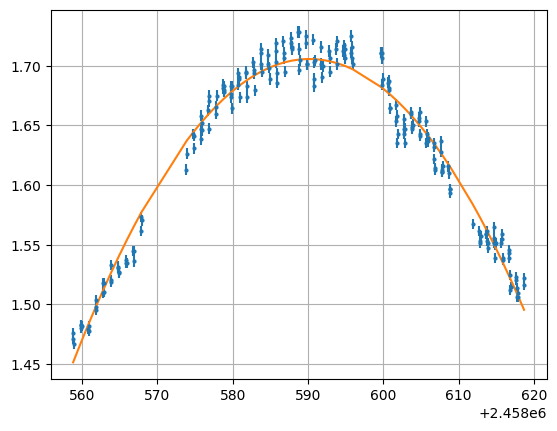

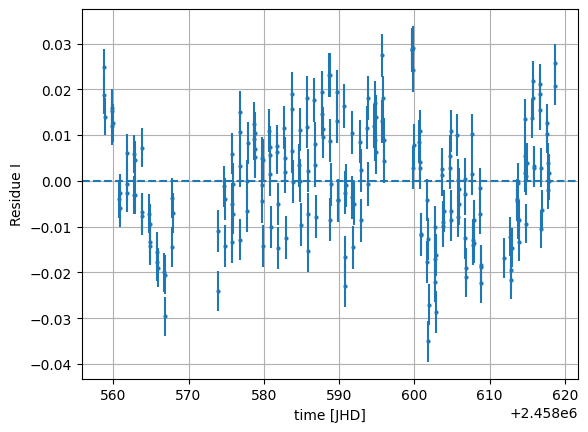

nsigma with ogle params:
t0_ogle: 2458590.330±0.026
t0_par: 2458590.167±0.178
nsigma: 0.9011629893998434

Imax_ogle: 1.717±0.000
Imax_par: 1.7056±0.0025
nsigma: 4.597770602005301


{'t0': t0_par: 2458590.167±0.178, 'Imax': Imax_par: 1.7056±0.0025}

In [18]:
mid_range=ms_event.data["JHD"][np.argmax(ms_event.data["I"])]
range_len=30
ms_event.parabolic_fit(mid_range, range_len)

In [ ]:
ms_event.bootstrap(mid_range, range_len, iter=10000)